# AutoML: 「最適な」画像オブジェクト検出モデルを学習する

**目的** - AutoML の画像オブジェクト検出ジョブの設定と実行方法について説明します。これは AutoML がサポートする9つの ML タスクのうちの1つです。他の ML タスクには、「予測」、「分類」、「画像オブジェクト検出」、「NLP テキスト分類」などがあります。

このノートブックでは、小さなデータセットを使って AutoML によりモデルを学習し、モデルの性能を最適化するためにモデルのハイパーパラメータを調整する方法を示し、推論シナリオで使用するモデルをデプロイします。

**前提条件** - このハンズオンでは、以下が前提条件となります:
- Machine Learning の基礎知識
- 利用可能な Azure subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- Azure ML workspace [Check this notebook for creating a workspace](../../../resources/workspace/workspace.ipynb) 
- Compute Cluster [Check this notebook to create a compute cluster](../../../resources/compute/compute.ipynb)
- Python 実行環境
- Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md)

**学習のゴール** - このハンズオンを完了すると、以下を学習できます:
- Python SDK から AML workspacce への接続方法
- 'image_object_detection()' 関数を使って `AutoML Image Object Detection Training Job` を実行する方法
- Azure Machine Learning のコンピュートで AutoML 機能を使ってモデルを構築する方法
- 学習済みモデルと推論スコアの取得 

# 1. Azure Machine Learning Workspace への接続

[Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) は Azure Machine Learning における最上位のリソースで、チームにおける機械学習成果物を作成し、関連作業をグループ化して管理する場所です。 実験、ジョブ、データセット、モデル、コンポーネント、推論エンドポイントなどの機械学習開発における成果物を統合し、共同作業を効率化することが可能です。
このセクションでは、ジョブを実行する Workspace に接続する。

## 1.1. Python ライブラリの import

In [1]:
# 必要なライブラリのインポート
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.automl import SearchSpace, ObjectDetectionPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Uniform,
    BanditPolicy,
)

from azure.ai.ml import automl

## 1.2. Workspace の詳細を設定し接続する

ワークスペースに接続するには、パラメータ情報（サブスクリプション、リソースグループ、ワークスペース名）が必要です。これらの情報を `azure.ai.ml` の `MLClient` で使用して、必要な Azure Machine Learning ワークスペースへ接続して各種操作を可能にします。このチュートリアルでは、デフォルトの [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) を使用します。

パラメータ情報（サブスクリプション、リソースグループ、ワークスペース名）を直接指定して接続することも可能です。パラメータについては、ワークスペースの右上のタブから確認することが可能です。

In [2]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

Found the config file in: /config.json


# 2. MLTable と入力トレーニングデータ

AutoML を用いてコンピュータビジョンのモデルを生成するには、モデルトレーニングの入力としてラベル付き画像データを MLTable の形式で提供する必要があります。MLTable は、様々なデータソースからのデータを統一的に扱うための抽象化された論理的なデータフォーマットを定義することが可能です。


ラベル付きトレーニングデータは JSONL 形式で MLTable を作成することができます。もしラベル付きトレーニングデータが異なる形式（例えば、pascal VOCやCOCOなど）である場合、まずそれをJSONL形式に変換するための変換スクリプトを使用し、その後で MLTable を作成できます。または、Azure Machine Learning のデータラベリングツールを使用して手動で画像にラベルを付け、ラベル付けされたデータをエクスポートして AutoML モデルのトレーニングに使用することもできます。

このノートブックでは、「Fridge Objects」とのデータセットを使用しています。これは、異なるシーンで撮影された4つのラベル（缶、紙パック、ミルクボトル、水ボトル）の飲料容器の写真128枚から構成されています。
このノートブックのすべての画像は[このリポジトリ](https://github.com/microsoft/computervision-recipes)にホストされており、[MIT license](https://github.com/microsoft/computervision-recipes/blob/master/LICENSE)の下で利用可能です。

## 2.1. データのダウンロード
まず、データをローカルにダウンロードして解凍します。デフォルトでは、データは現在のディレクトリ内の./dataフォルダにダウンロードされます。

データを別の場所にダウンロードしたい場合は、次のセルのdataset_parent_dir = ...を更新してください。

In [3]:
import os
import urllib
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = "./data"

# create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"

# Extract current dataset name from dataset url
dataset_name = os.path.split(download_url)[-1].split(".")[0]
# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Download the dataset
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path=dataset_parent_dir)
    print("done")
# delete zip file
os.remove(data_file)

extracting files...
done


データセット内のサンプル画像データを確認

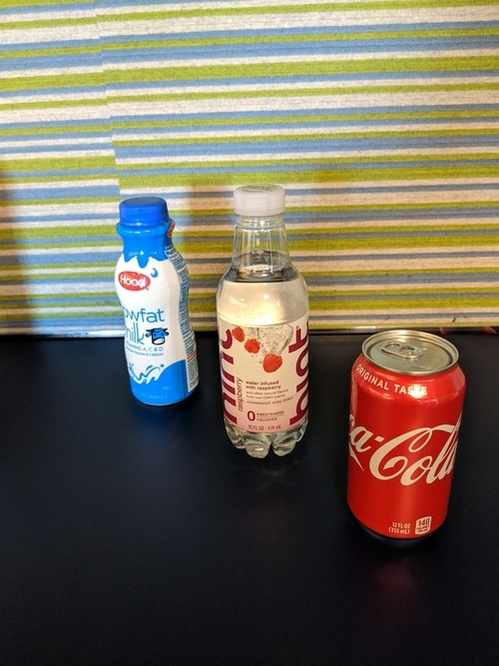

In [4]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images", "31.jpg")
Image(filename=sample_image)

## 2.2. AML データアセット（URIフォルダ）としてデータストアに画像をアップロードする。

Azure ML でモデルトレーニングにデータを利用するために、ワークスペースのデフォルト Blob Storage にデータをアップロードします。

[Check this notebook for AML data asset example](../../../assets/data/data.ipynb)

In [5]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images Object detection",
    name="fridge-items-images-object-detection",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

Uploading odFridgeObjects (20.54 MBs): 100%|██████████| 20537223/20537223 [00:01<00:00, 14646979.74it/s]




creation_context:
  created_at: '2024-04-05T13:37:52.302542+00:00'
  created_by: Hiroaki Ishida
  created_by_type: User
  last_modified_at: '2024-04-05T13:37:52.311977+00:00'
description: Fridge-items images Object detection
id: /subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl-handson/providers/Microsoft.MachineLearningServices/workspaces/aml-automl-handson-aml/data/fridge-items-images-object-detection/versions/1
name: fridge-items-images-object-detection
path: azureml://subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/workspaces/aml-automl-handson-aml/datastores/workspaceblobstore/paths/LocalUpload/16df78f2a80a586b282ca9f470300549/odFridgeObjects/
properties: {}
tags: {}
type: uri_folder
version: '1'


Path to folder in Blob Storage:
azureml://subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/workspaces/aml-automl-handson-aml/datastores/workspaceblobstore/paths/LocalUpload/16df78f2a80a5

## 2.3. ダウンロードしたデータを JSONL 形式に変換

この例では、冷蔵庫オブジェクトのデータセットが Pascal VOC 形式でアノテーションされており、各画像にはxmlファイルが対応しています。各xmlファイルには、対応する画像ファイルの場所と、バウンディングボックスおよびオブジェクトラベルに関する情報が含まれています。

このデータを AzureML MLTable で使用するためには、特定の JSONL 形式に変換する必要があります。以下のスクリプトは、対応する MLTable フォルダ内に2つの .jsonl ファイル（1つはトレーニング用、もう1つはバリデーション用）を作成します。トレーニング/バリデーションの比率は、4:1 とします。AutoML で画像分類タスクに使用される jsonl ファイルの詳細については、[ドキュメント](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema#object-detection)を参照してください。

## JSONLファイルを生成する

JSONL 変換コードは pycocotools と simplification パッケージを必要とします。

In [8]:
!/anaconda/envs/azureml_py310_sdkv2/bin/pip install pycocotools
!/anaconda/envs/azureml_py310_sdkv2/bin/pip install simplification
!/anaconda/envs/azureml_py310_sdkv2/bin/pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.2/709.2 kB 19.8 MB/s eta 0:00:0000:01


In [10]:
!/anaconda/envs/azureml_py310_sdkv2/bin/pip install torch==1.12.0+cu102 torchvision==0.13.0+cu102 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu102

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 32.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 20.1 MB/s eta 0:00:0000:0100:01m


In [11]:
import sys

sys.path.insert(0, "../jsonl-conversion/")
from base_jsonl_converter import write_json_lines
from voc_jsonl_converter import VOCJSONLConverter

base_url = os.path.join(uri_folder_data_asset.path, "images/")
converter = VOCJSONLConverter(base_url, os.path.join(dataset_dir, "annotations"))
jsonl_annotations = os.path.join(dataset_dir, "annotations_voc.jsonl")
write_json_lines(converter, jsonl_annotations)

Parsing ./data/odFridgeObjects/annotations/1.xml
Parsing ./data/odFridgeObjects/annotations/10.xml
Parsing ./data/odFridgeObjects/annotations/100.xml
Parsing ./data/odFridgeObjects/annotations/101.xml
Parsing ./data/odFridgeObjects/annotations/102.xml
Parsing ./data/odFridgeObjects/annotations/103.xml
Parsing ./data/odFridgeObjects/annotations/104.xml
Parsing ./data/odFridgeObjects/annotations/105.xml
Parsing ./data/odFridgeObjects/annotations/106.xml
Parsing ./data/odFridgeObjects/annotations/107.xml
Parsing ./data/odFridgeObjects/annotations/108.xml
Parsing ./data/odFridgeObjects/annotations/109.xml
Parsing ./data/odFridgeObjects/annotations/11.xml
Parsing ./data/odFridgeObjects/annotations/110.xml
Parsing ./data/odFridgeObjects/annotations/111.xml
Parsing ./data/odFridgeObjects/annotations/112.xml
Parsing ./data/odFridgeObjects/annotations/113.xml
Parsing ./data/odFridgeObjects/annotations/114.xml
Parsing ./data/odFridgeObjects/annotations/115.xml
Parsing ./data/odFridgeObjects/anno

## トレーニング/バリデーションにデータを分割

In [12]:
import os

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "training-mltable-folder")
validation_mltable_path = os.path.join(dataset_parent_dir, "validation-mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

with open(jsonl_annotations, "r") as annot_f:
    json_lines = annot_f.readlines()

index = 0
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for json_line in json_lines:
            if index % train_validation_ratio == 0:
                # validation annotation
                validation_f.write(json_line)
            else:
                # train annotation
                train_f.write(json_line)
            index += 1

## 2.4. アノテーションファイルを COCO からJSONL に変換する
COCO 形式のデータセットを使ってみたい場合は、以下のスクリプトで`jsonl`形式に変換することができます。odFridgeObjects_coco.json ファイルは `odFridgeObjects` データセットのアノテーション情報から構成されています。

In [13]:
import sys

sys.path.insert(0, "../jsonl-conversion/")
from base_jsonl_converter import write_json_lines
from coco_jsonl_converter import COCOJSONLConverter

base_url = os.path.join(uri_folder_data_asset.path, "images/")
print(base_url)
converter = COCOJSONLConverter(base_url, "./odFridgeObjects_coco.json")
jsonl_annotations = os.path.join(dataset_dir, "annotations_coco.jsonl")
write_json_lines(converter, jsonl_annotations)

azureml://subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/workspaces/aml-automl-handson-aml/datastores/workspaceblobstore/paths/LocalUpload/16df78f2a80a586b282ca9f470300549/odFridgeObjects/images/
Conversion completed. Converted 128 lines.


### バウンディング・ボックスの可視化
以下の[チュートリアル](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models#visualize-data)の "データの可視化 "セクションを参照して、トレーニングを開始する前に、グランドトゥルースのバウンディングボックスを簡単に可視化する方法を確認してください。

## 2.5. MLTable 作成
上記で作成したjsonlファイルを使ってMLTableデータ入力を作成します。

このノートブック以外のジョブのために独自の MLTable アセットを作成するドキュメントについては、以下のリソースを参照してください。
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [14]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)


# Create and save train mltable
train_mltable_file_contents = create_ml_table_file(
    os.path.basename(train_annotations_file)
)
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Save train and validation mltable
validation_mltable_file_contents = create_ml_table_file(
    os.path.basename(validation_annotations_file)
)
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [15]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes

# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")

V1 SDK を使用して作成した TabularDataset からデータ入力を作成するには、`type`に `AssetTypes.MLTABLE`、`mode`に `InputOutputModes.DIRECT`、`path`に `azureml:<tabulardataset_name>:<version>` という形式で指定します。

In [16]:
"""
# Training MLTable with v1 TabularDataset
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsTrainingDataset:1",
    mode=InputOutputModes.DIRECT
)

# Validation MLTable with v1 TabularDataset
my_validation_data_input = Input(
    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsValidationDataset:1",
    mode=InputOutputModes.DIRECT
)
"""

'\n# Training MLTable with v1 TabularDataset\nmy_training_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsTrainingDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n\n# Validation MLTable with v1 TabularDataset\nmy_validation_data_input = Input(\n    type=AssetTypes.MLTABLE, path="azureml:odFridgeObjectsValidationDataset:1",\n    mode=InputOutputModes.DIRECT\n)\n'

# 3. コンピュートターゲットの設定

AutoML モデルのトレーニングに使用される[コンピュートターゲット](https://docs.microsoft.com/ja-jp/azure/machine-learning/concept-azure-machine-learning-architecture#computes)を提供する必要があります。画像タスク用の AutoML モデルには、NC、NCv2、NCv3、ND、NDv2、NCasT4 シリーズなどの[GPU SKU](https://docs.microsoft.com/ja-jp/azure/virtual-machines/sizes-gpu)が必要です。より高速なトレーニングのために、NCsv3 シリーズ（v100 GPUを搭載）の使用を推奨します。マルチ GPU VM SKUを備えたコンピュート ターゲットを使用すると、複数の GPU を活用してトレーニング速度を向上させることができます。さらに、複数のノードを備えたコンピュート ターゲットを設定すると、モデルのハイパーパラメータをチューニングする際に並列性を活用して、より速くモデルトレーニングを行うことができます。

In [17]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "gpu-cluster-nc6s"

try:
    _ = ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC6s_v3",
        idle_time_before_scale_down=120,
        min_instances=0,
        max_instances=4,
    )
    ml_client.begin_create_or_update(compute_config).result()

Creating a new compute target...


# 4. オブジェクト検出トレーニングのための AutoML の設定と実行

AutoML を使用すると、画像データに対して画像分類、オブジェクト検出、セグメンテーションのモデルを簡単にトレーニングすることができます。使用するモデルアルゴリズムとハイパーパラメータを制御したり、手動で指定したハイパーパラメータ空間上でのスイープを実行したり、システムによって自動的にハイパーパラメータスイープを行わせることができます。

## 4.1. モデルの自動ハイパーパラメータスイープ（AutoMode）

AutoML for Imagesを使用する際、最適なモデルを見つけるために自動ハイパーパラメータスイープを実行することができます（この機能をAutoModeと呼びます）。最初のベースラインモデルを取得するには、最初に自AutoModeで実施することをお勧めします。AutoMLにより、モデルアーキテクチャや学習率（learning_rate）、エポック数（number_of_epochs）、トレーニングバッチサイズ（training_batch_size）などの値が決定され、複数パターン自動で試行されます。ハイパーパラメータの検索空間、サンプリング方法、早期終了ポリシーを指定する必要はありません。多くのデータセットに対して、10から20回の実行でうまく機能するでしょう。

AutoModeは、`max_trials`を1より大きい値に設定し、ハイパーパラメータ空間、サンプリング方法、終了ポリシーを省略することでトリガーされます。

以下の関数は、自動スイープのためのAutoMLジョブを設定します：
### image_object_detection() 関数のパラメータ:
`image_object_detection()`関数を使用すると、トレーニングジョブを設定できます。

- `compute` - AutoMLジョブが実行されるコンピュート。この例では、ワークスペースに存在する'gpu-cluster'というコンピュートを使用しています。ワークスペース内の他のコンピュートに置き換えることができます。
- `experiment_name` - 実験の名前。実験は、論理的な機械学習実験に関連する複数の実行を含むAzure MLワークスペース内のフォルダのようなものです。
- `name` - ジョブ/実行の名前。これはオプションのプロパティです。指定されていない場合、ランダムな名前が生成されます。
- `primary_metric` - AutoMLがモデル選択のために最適化するメトリック。
- `target_column_name` - 予測の対象となる列の名前。常に指定する必要があります。このパラメータは'training_data'および'validation_data'に適用されます。
- `training_data` - トレーニングに使用されるデータ。トレーニング特徴列とターゲット列の両方を含むべきです。オプションで、このデータはバリデーションまたはテストデータセットを分離するために分割することができます。
ワークスペースで登録されたMLTableを'<mltable_name>:<version>'の形式で使用することも、ローカルファイルやフォルダをMLTableとして使用することもできます。例：Input(mltable='my_mltable:1')またはInput(mltable=MLTable(local_path="./data"))
`training_data`パラメータは常に提供される必要があります。

### set_limits() 関数のパラメータ:
これは、タイムアウトなどの制限パラメータを設定するためのオプションの設定方法です。

- `timeout_minutes` - AutoMLジョブのタイムアウト時間（分）です。指定されていない場合、ジョブの総タイムアウトのデフォルトは6日間（8,640分）です。
- `max_trials` - スイープする最大の設定数。1から1000の間の整数でなければなりません。特定のモデルアルゴリズムのデフォルトハイパーパラメータのみを探索する場合、このパラメータを1に設定します。デフォルト値は1です。
- `max_concurrent_trials` - 同時に実行できる最大実行数。指定されていない場合、すべての実行が並行して開始されます。指定される場合、1から100の間の整数でなければなりません。デフォルト値は1です。
    注：同時実行数は、指定されたコンピュートターゲットで利用可能なリソースによって制限されます。要件に基づいて、コンピュートターゲットに十分なリソースがあることを確認してください。

In [18]:
# general job parameters
exp_name = "dpv2-image-object-detection-experiment"

In [19]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric="mean_average_precision",
    tags={"my_custom_tag": "My custom value"},
)

image_object_detection_job.set_limits(
    max_trials=10,
    max_concurrent_trials=2,
)

### Computer Vision 用の AutoML Job を Submit する
ジョブの設定が完了したら、トレーニングデータセットを使ってビジョンモデルをトレーニングするために、ジョブを送信します。

In [20]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Uploading training-mltable-folder (0.07 MBs): 100%|██████████| 72267/72267 [00:00<00:00, 679325.87it/s]


Uploading validation-mltable-folder (0.02 MBs): 100%|██████████| 18346/18346 [00:00<00:00, 289585.66it/s]




Created job: compute: azureml:gpu-cluster-nc6s
creation_context:
  created_at: '2024-04-05T14:10:31.580518+00:00'
  created_by: Hiroaki Ishida
  created_by_type: User
display_name: bold_screw_smfr9rl35k
experiment_name: dpv2-image-object-detection-experiment
id: azureml:/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl-handson/providers/Microsoft.MachineLearningServices/workspaces/aml-automl-handson-aml/jobs/bold_screw_smfr9rl35k
limits:
  max_concurrent_trials: 2
  max_trials: 10
  timeout_minutes: 10080
log_verbosity: info
name: bold_screw_smfr9rl35k
outputs: {}
primary_metric: mean_average_precision
properties: {}
resources:
  instance_count: 1
  shm_size: 2g
services:
  Studio:
    endpoint: https://ml.azure.com/runs/bold_screw_smfr9rl35k?wsid=/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/workspaces/aml-automl-handson-aml&tid=16b3c013-d300-468d-ac64-7eda0820b6d3
  Tracking:
    endpoint: azureml://eastus.api.azurem

In [29]:
# temp code
returned_job = ml_client.jobs.get(name="bold_screw_smfr9rl35k")
dataset_dir = "./data/odFridgeObjects"

In [4]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

In [12]:
ml_client.jobs.stream(returned_job.name)

RunId: bold_screw_smfr9rl35k
Web View: https://ml.azure.com/runs/bold_screw_smfr9rl35k?wsid=/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/workspaces/aml-automl-handson-aml


JobException: The output streaming for the run interrupted.
But the run is still executing on the compute target. 
Details for canceling the run can be found here: https://aka.ms/aml-docs-cancel-run

## 4.2. 【オプション】個別の実行

AutoMode が要件に合わない場合、モデルアルゴリズムを探索するために個別の実行を行うことができます。各アルゴリズムに対して適切なデフォルトのハイパーパラメータを提供しています。また、同じモデルアルゴリズムに対して異なるハイパーパラメータの組み合わせで個別の実行を行うこともできます。モデルアルゴリズムは`model_name`パラメータを使用して指定されます。サポートされているモデルアルゴリズムのリストについては、[ドキュメント](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters)を参照してください。

以下の関数を使用して、個別の実行のためのAutoMLジョブを設定できます：
### set_training_parameters() 関数のパラメータ:
これは、パラメータ空間のスイープ中に変更されない固定設定やパラメータを設定するためのオプションの設定方法です。この関数の主なパラメータには以下が含まれます：

- `model_name` - トレーニングジョブで使用したいMLアルゴリズムの名前。サポートされているモデルアルゴリズムについては、この[ドキュメント](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#supported-model-algorithms)を参照してください。
- `number_of_epochs` - トレーニングのエポック数。正の整数でなければなりません（デフォルト値は15）。
- `layers_to_freeze` - 転移学習のために凍結するモデルのレイヤー数。正の整数でなければなりません（デフォルト値は0）。
- `early_stopping` - トレーニング中に早期終了ロジックを有効にします。ブール値でなければなりません（デフォルトはTrue）。
- `optimizer` - トレーニングで使用するオプティマイザーのタイプ。sgd、adam、adamwのいずれかでなければなりません（デフォルトはsgd）。
- `distributed` - 計算ターゲットが複数のGPUを含む場合に分散トレーニングを有効にします。ブール値でなければなりません（デフォルトはTrue）。

特定のアルゴリズム（例えば`yolov5`）のデフォルトのハイパーパラメータ値を使用したい場合、AutoML Image実行のジョブを次のように指定できます：

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

# Set limits
image_object_detection_job.set_limits(timeout_minutes=60)

# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(model_name="yolov5")

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_object_detection_job)

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

### 4.2.1 MMDetectionのモデルを使用した個別実行（プレビュー）

AutoMLがネイティブにサポートするモデルに加えて、オブジェクト検出をサポートするMMDetectionバージョン2.28.2の任意のモデルを使用して個別実行を行うことができます。使用可能なモデルのリストについては、この[ドキュメント](https://github.com/open-mmlab/mmdetection/blob/v2.28.2/docs/en/model_zoo.md)を参照してください。

MMDetectionの任意のモデルをこのタスクに使用できますが、当社ではレジストリ内で一連のモデルを厳選しています。これらのモデルには、合理的なデフォルトのハイパーパラメーターを提供しています。厳選されたモデルのリストを以下のコードスニペットを使用して取得することができます。

In [ ]:
registry_ml_client = MLClient(credential, registry_name="azureml")

models = registry_ml_client.models.list()
object_detection_models = []
for model in models:
    try:
        model = registry_ml_client.models.get(model.name, label="latest")
        if model.tags.get("task", "") == "object-detection":
            object_detection_models.append(model.name)
    except Exception as ex:
        print(f"Error while accessing registry model list: {ex}")

object_detection_models

If you wish to try a model (say `vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco`), you can specify the job for your AutoML Image runs as follows:

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
)

# Set limits
image_object_detection_job.set_limits(timeout_minutes=60)

# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(
    model_name="vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco"
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_object_detection_job)

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

## 4.3. Manual hyperparameter sweeping for your model

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for `yolov5` and `fasterrcnn_resnet50_fpn` models, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories, choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc., to generate a model with the optimal 'mean_average_precision'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

set_sweep function is used to configure the sweep settings:
### set_sweep() parameters:
- `sampling_algorithm` - Sampling method to use for sweeping over the defined parameter space. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#sampling-methods-for-the-sweep) for list of supported sampling methods.
- `early_termination` - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#early-termination-policies) for supported early termination policies.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ObjectDetectionPrimaryMetrics.MEAN_AVERAGE_PRECISION,
    tags={"my_custom_tag": "My custom value"},
)

In [ ]:
# Set limits
image_object_detection_job.set_limits(
    timeout_minutes=60,
    max_trials=10,
    max_concurrent_trials=2,
)

In [ ]:
# Pass the fixed settings or parameters
image_object_detection_job.set_training_parameters(
    early_stopping=True, evaluation_frequency=1
)

In [ ]:
# Configure sweep settings
image_object_detection_job.set_sweep(
    sampling_algorithm="random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

In [ ]:
# Define search space
image_object_detection_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["yolov5"]),
            learning_rate=Uniform(0.0001, 0.01),
            model_size=Choice(["small", "medium"]),  # model-specific
            # image_size=Choice(640, 704, 768),  # model-specific; might need GPU with large memory
        ),
        SearchSpace(
            model_name=Choice(["fasterrcnn_resnet50_fpn"]),
            learning_rate=Uniform(0.0001, 0.001),
            optimizer=Choice(["sgd", "adam", "adamw"]),
            min_size=Choice([600, 800]),  # model-specific
            # warmup_cosine_lr_warmup_epochs=Choice([0, 3]),
        ),
    ]
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child jobs' tab in the UI of the main automl image job from above, which is the HyperDrive parent run. Then you can go into the 'Trials' tab of this HyperDrive parent run. Alternatively, here below you can see directly the HyperDrive parent run and navigate to its 'Trials' tab:

In [ ]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

### 4.3.1 Manual hyperparameter sweeping for models from MMDetection (Preview)

Similar to how you can use any model from MMDetection version 2.28.2 for individual runs, you can also include these models to perform a hyperparameter sweep. You can also choose a combination of models supported natively by [AutoML](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) and models from [MMDetection](https://github.com/open-mmlab/mmdetection/blob/v2.28.2/docs/en/model_zoo.md).

In this example, we sweep over `deformable_detr_twostage_refine_r50_16x2_50e_coco`, `sparse_rcnn_r50_fpn_300_proposals_crop_mstrain_480-800_3x_coco`, and `yolov5`, models choosing from a range of values for learning_rate, model_size, etc., to generate a model with the optimal 'MeanAveragePrecision'..

In [ ]:
# Create the AutoML job with the related factory-function.

image_object_detection_job = automl.image_object_detection(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ObjectDetectionPrimaryMetrics.MEAN_AVERAGE_PRECISION,
    tags={"my_custom_tag": "My custom value"},
)

# Set limits
image_object_detection_job.set_limits(
    timeout_minutes=240,
    max_trials=10,
    max_concurrent_trials=2,
)

# Configure sweep settings
image_object_detection_job.set_sweep(
    sampling_algorithm="random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

# Define search space
image_object_detection_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["yolov5"]),
            learning_rate=Uniform(0.0001, 0.01),
            model_size=Choice(["small", "medium"]),  # model-specific
        ),
        SearchSpace(
            model_name=Choice(
                [
                    "deformable_detr_twostage_refine_r50_16x2_50e_coco",
                    "sparse_rcnn_r50_fpn_300_proposals_crop_mstrain_480-800_3x_coco",
                ]
            ),
            learning_rate=Uniform(0.00001, 0.0001),
            number_of_epochs=Choice([15, 20]),
        ),
    ]
)

In [ ]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    image_object_detection_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
ml_client.jobs.stream(returned_job.name)

# 5. 最良モデルの取得
MLFLowClient を使用して、完了した AutoML トライアルの結果（モデル、成果物、メトリクスなど）にアクセスします。

Azure Machine Learning ワークスペースは、MLflow と互換性があります。つまり、追加の構成なしで MLflow サーバーとして機能できます。 各ワークスペースには、MLflow によってワークスペースに接続するために使用される MLflow 追跡 URI があります。 Azure Machine Learning ワークスペースは、MLflow と連携するように既に構成されているため、追加の構成は不要です。

## MLFlow クライアントの初期化

AutoML によって作成されたモデルと成果物には MLFlow のインターフェースからアクセスできます。

ここで MLFlow クライアントを初期化し、MLFlow クライアント経由でバックエンドを Azure ML に設定します。


重要: MLFlow の最新ライブラリをインストールする必要があります。

    pip install azureml-mlflow

    pip install mlflow

In [6]:
!/anaconda/envs/azureml_py310_sdkv2/bin/pip install azureml-mlflow
!/anaconda/envs/azureml_py310_sdkv2/bin/pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: azure-storage-blob
    Found existing installation: azure-storage-blob 12.16.0
    Uninstalling azure-storage-blob-12.16.0:
      Successfully uninstalled azure-storage-blob-12.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
azure-storage-file-datalake 12.11.0 requires azure-storage-blob<13.0.0,>=12.16.0b1, but you have azure-storage-blob 12.13.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
      Successfully uninstalled click-8.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

### MLFlow の tracking URIを取得する

In [5]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl-handson/providers/Microsoft.MachineLearningServices/workspaces/aml-automl-handson-aml


In [6]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://eastus.api.azureml.ms/mlflow/v1.0/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl-handson/providers/Microsoft.MachineLearningServices/workspaces/aml-automl-handson-aml


In [7]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### AutoML parent Job を取得する

In [8]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'log_loss': 0.2073379926956617,
 'log_loss_train': 0.3363722334889805,
 'mean_average_precision': 0.99826,
 'precision': 0.90872,
 'recall': 1.0}, params={}, tags={'automl_best_child_run_id': 'bold_screw_smfr9rl35k_HD_7',
 'fit_time_000': 'NaN',
 'is_gpu': 'True',
 'iteration_000': '0',
 'mlflow.rootRunId': 'bold_screw_smfr9rl35k',
 'mlflow.runName': 'bold_screw_smfr9rl35k',
 'mlflow.user': 'Hiroaki Ishida',
 'model_explain_run': 'best_run',
 'my_custom_tag': 'My custom value',
 'pipeline_id_000': 'UnkownPipelineId',
 'predicted_cost_000': '0',
 'run_algorithm_000': '',
 'run_preprocessor_000': '',
 'score_000': '1',
 'training_percent_000': '0'}>, info=<RunInfo: artifact_uri='azureml://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl-handson/providers/Microsoft.MachineLearningServices/workspaces/aml-automl-handson-aml/experiments/06702547-e6de-4b24-b86d-4660b1098494/runs/bold_screw

In [9]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

{'my_custom_tag': 'My custom value', 'model_explain_run': 'best_run', 'is_gpu': 'True', 'pipeline_id_000': 'UnkownPipelineId', 'score_000': '1', 'predicted_cost_000': '0', 'fit_time_000': 'NaN', 'training_percent_000': '0', 'iteration_000': '0', 'run_preprocessor_000': '', 'run_algorithm_000': '', 'automl_best_child_run_id': 'bold_screw_smfr9rl35k_HD_7', 'mlflow.rootRunId': 'bold_screw_smfr9rl35k', 'mlflow.runName': 'bold_screw_smfr9rl35k', 'mlflow.user': 'Hiroaki Ishida'}


### AutoML の最良のジョブ（試行）を取得する

In [10]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id: bold_screw_smfr9rl35k_HD_7
Best child run: 
<Run: data=<RunData: metrics={'log_loss': 0.2073379926956617,
 'log_loss_train': 0.3363722334889805,
 'mean_average_precision': 0.99826,
 'precision': 0.90872,
 'recall': 1.0}, params={}, tags={'hyperparameters': '{"model": {"img_size": 960, "learning_rate": '
                    '0.014757568202167793, "model_name": "yolov5", '
                    '"model_size": "medium", "training_batch_size": 6, '
                    '"validation_batch_size": 9, "weight_decay": '
                    '0.000740896407509669}}',
 'mlflow.parentRunId': 'bold_screw_smfr9rl35k_HD',
 'mlflow.rootRunId': 'bold_screw_smfr9rl35k',
 'mlflow.runName': 'stoic_brick_gpm8bt43',
 'mlflow.source.name': 'hd_object_detection_dnn_driver.py',
 'mlflow.source.type': 'JOB',
 'mlflow.user': 'Hiroaki Ishida'}>, info=<RunInfo: artifact_uri='azureml://eastus.api.azureml.ms/mlflow/v2.0/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl

## 最良モデルのメトリクスを取得する
実行したAutoMLのメトリクスにアクセスします。

In [11]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
log_loss,0.207338
precision,0.908720
log_loss_train,0.336372
recall,1.000000
mean_average_precision,0.998260


## 最良モデルをダウンロード
実行したAutoMLの結果（モデル、成果物、メトリクスなど）にアクセスします。

In [12]:
# Create local folder
local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [13]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print(f"Artifacts downloaded in: {local_path}")
print(f"Artifacts: {os.listdir(local_path)}")

/tmp/ipykernel_5735/3419855211.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.download_artifacts`` is deprecated since 2.0. This method will be removed in a future release. Use ``mlflow.artifacts.download_artifacts`` instead.
  local_path = mlflow_client.download_artifacts(


Artifacts downloaded in: /mnt/batch/tasks/shared/LS_root/mounts/clusters/hishida3/code/Users/hishida/automl-image-object-detection-task-fridge-items/artifact_downloads/outputs
Artifacts: ['.amlignore', '.amlignore.amltmp', 'conda_env_v_1_0_0.yml', 'generated_code', 'mlflow-model', 'model.pt', 'run_id.txt', 'scoring_file_v_1_0_0.py']


In [14]:
import os

mlflow_model_dir = os.path.join(local_dir, "outputs", "mlflow-model")

# Show the contents of the MLFlow model folder
os.listdir(mlflow_model_dir)

# You should see a list of files such as the following:
# ['artifacts', 'conda.yaml', 'MLmodel', 'python_env.yaml', 'python_model.pkl', 'requirements.txt']

['artifacts',
 'conda.yaml',
 'MLmodel',
 'python_env.yaml',
 'python_model.pkl',
 'requirements.txt']

# 6. 最良モデルを登録・デプロイする

## 6.1 マネージドオンラインエンドポイントを作成
マネージドオンラインエンドポイントを作成します。マネージドオンラインエンドポイントはリアルタイムの推論リクエストの処理をサーバレスで提供します。


In [15]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

In [16]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime

online_endpoint_name = "od-fridge-items-" + datetime.datetime.now().strftime(
    "%m%d%H%M%f"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for deploying model",
    auth_mode="key",
    tags={"foo": "bar"},
)
print(online_endpoint_name)

od-fridge-items-04060535826236


In [17]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://od-fridge-items-04060535826236.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://od-fridge-items-04060535826236.eastus.inference.ml.azure.com/swagger.json', 'name': 'od-fridge-items-04060535826236', 'description': 'this is a sample online endpoint for deploying model', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/providers/microsoft.machinelearningservices/workspaces/aml-automl-handson-aml/onlineendpoints/od-fridge-items-04060535826236', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:023deea1-aeac-4f09-b561-9d6cc37d1b61:8f6e6f04-f5cd-4323-8e23-738edbbdea21?api-version=2022-02-01-preview'}, 'print_as_yaml': Tru

## 6.2 最良モデルを登録・デプロイ

### Register model

In [18]:
model_name = "od-fridge-items-mlflow-model"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="my sample object detection model",
    type=AssetTypes.MLFLOW_MODEL,
)

# for downloaded file
# model = Model(
#     path=mlflow_model_dir,
#     name=model_name,
#     description="my sample object detection model",
#     type=AssetTypes.MLFLOW_MODEL,
# )

registered_model = ml_client.models.create_or_update(model)

In [19]:
registered_model.id

'/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourceGroups/aml-automl-handson/providers/Microsoft.MachineLearningServices/workspaces/aml-automl-handson-aml/models/od-fridge-items-mlflow-model/versions/3'

### Deploy

In [20]:
from azure.ai.ml.entities import OnlineRequestSettings

# Setting the request timeout to 90 seconds. Please note that if you use a GPU compute, inference would be faster
# and this setting may not be required.
req_timeout = OnlineRequestSettings(request_timeout_ms=90000)

In [21]:
deployment = ManagedOnlineDeployment(
    name="od-fridge-items-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_DS4_V2",
    instance_count=1,
    request_settings=req_timeout,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [22]:
ml_client.online_deployments.begin_create_or_update(deployment).result()

Check: endpoint od-fridge-items-04060535826236 exists


...........................................................................................................................................................................................................................................................................................................................................................................

In [26]:
# od fridge items deployment to take 100% traffic
endpoint.traffic = {"od-fridge-items-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

Readonly attribute principal_id will be ignored in class <class 'azure.ai.ml._restclient.v2022_05_01.models._models_py3.ManagedServiceIdentity'>
Readonly attribute tenant_id will be ignored in class <class 'azure.ai.ml._restclient.v2022_05_01.models._models_py3.ManagedServiceIdentity'>


ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://od-fridge-items-04060535826236.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://od-fridge-items-04060535826236.eastus.inference.ml.azure.com/swagger.json', 'name': 'od-fridge-items-04060535826236', 'description': 'this is a sample online endpoint for deploying model', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/resourcegroups/aml-automl-handson/providers/microsoft.machinelearningservices/workspaces/aml-automl-handson-aml/onlineendpoints/od-fridge-items-04060535826236', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f6ce1e2a-5984-4caf-a25c-b84249640c08/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oe:023deea1-aeac-4f09-b561-9d6cc37d1b61:e6417231-fc16-440b-8724-84d9e4431ae8?api-version=2022-02-01-preview'}, 'print_as_yaml': Tru

### Get endpoint details

In [27]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'od-fridge-items-mlflow-deploy': 100}
https://od-fridge-items-04060535826236.eastus.inference.ml.azure.com/score


### Test the deployment

In [30]:
# Create request json
import base64

sample_image = os.path.join(dataset_dir, "images", "1.jpg")


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

In [31]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [32]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image.

carton: [95.986, 169.222, 145.483, 353.117], 0.782


<Figure size 1800x1200 with 0 Axes>

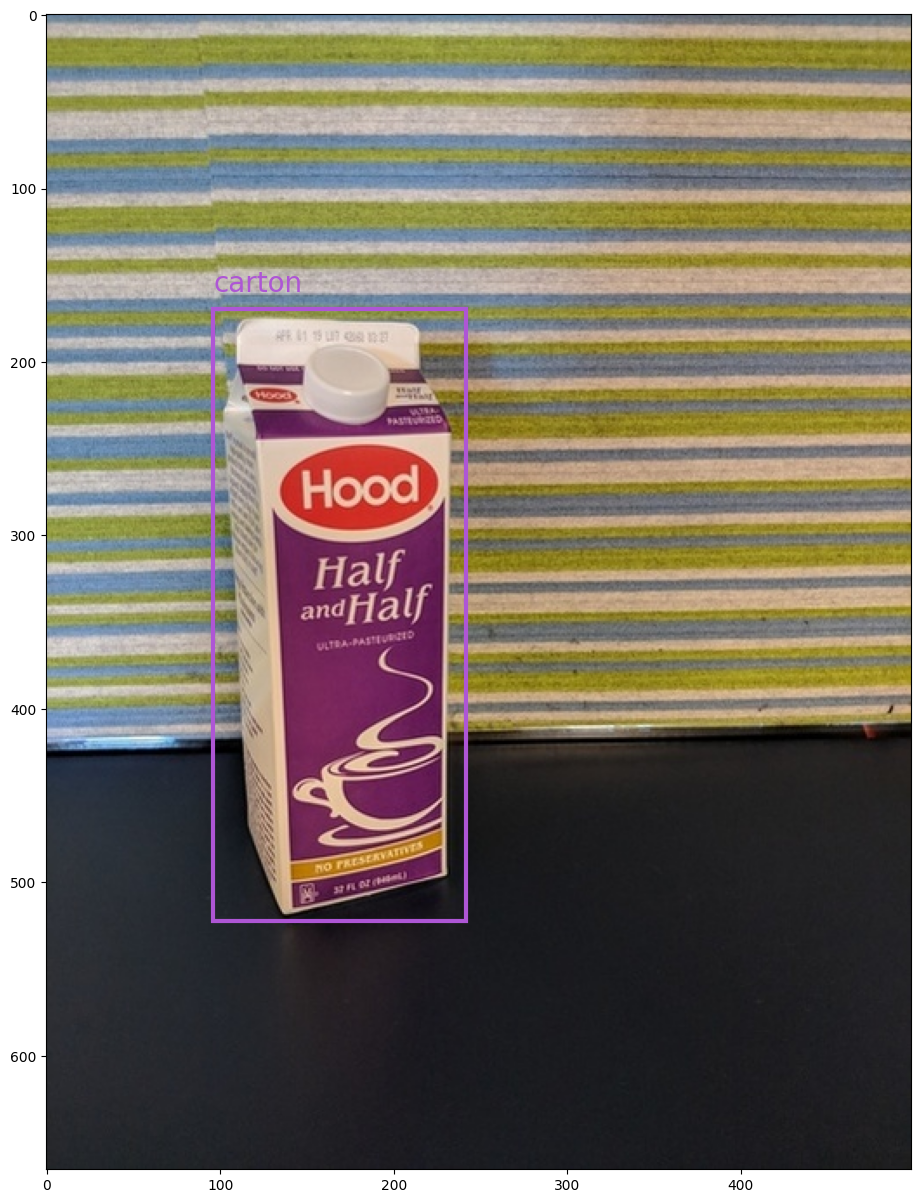

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = json.loads(resp)
for detect in detections[0]["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            f"{detect['label']}: [{round(topleft_x, 3)}, {round(topleft_y, 3)}, "
            f"{round(width, 3)}, {round(height, 3)}], {round(conf_score, 3)}"
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()

### Delete the deployment and endopoint

In [ ]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)

# Next Step: Load the best model and try predictions

Loading the models locally assume that you are running the notebook in an environment compatible with the model. The list of dependencies that is expected by the model is specified in the MLFlow model produced by AutoML (in the 'conda.yaml' file within the mlflow-model folder).

Since the AutoML model was trained remotelly in a different environment with different dependencies to your current local conda environment where you are running this notebook, if you want to load the model you have several options:

1. A recommended way to locally load the model in memory and try predictions is to create a new/clean conda environment with the dependencies specified in the conda.yaml file within the MLFlow model's folder, then use MLFlow to load the model and call .predict() as explained in the notebook **mlflow-model-local-inference-test.ipynb** in this same folder.

2. You can install all the packages/dependencies specified in conda.yaml into your current conda environment you used for using Azure ML SDK and AutoML. MLflow SDK also have a method to install the dependencies in the current environment. However, this option could have risks of package version conflicts depending on what's installed in your current environment.

3. You can also use: mlflow models serve -m 'xxxxxxx'

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Classification, NLP-Text-Classification, Time-Series-Forcasting, etc.